In [1]:
import theano
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
import numpy as np
import sys
import os
sys.path.append("../lib")
from load import getValData
from load import faces
import pickle
from theano.tensor.nnet.conv import conv2d
from theano.tensor.signal.downsample import max_pool_2d
from six.moves import cPickle


Using gpu device 0: GeForce GTX 980


In [2]:
# trX, teX, trY, teY = mnist(onehot=True)

# trX = trX.reshape(-1, 1, 28, 28)
# teX = teX.reshape(-1, 1, 28, 28)

trX, teX, trY, teY = faces(onehot=True)

ValX , ValY = getValData()



In [3]:
trX = trX.reshape(-1, 1, 48, 48)
teX = teX.reshape(-1, 1, 48, 48)
ValX = ValX.reshape(-1, 1, 48, 48)

In [4]:
testCount = np.sum(teY , axis = 0)
trainCount = np.sum(ValY , axis = 0)
print testCount , trainCount

[467  56 496 895 653 415 607] [ 437  457  424  758  441  459 1202]


In [5]:
r = len(ValY)
i = 0
while i < r:
    if(ValY[i][6] == 1):
        ValX = np.delete(ValX , i , 0)
        ValY = np.delete(ValY , i , 0)
        i = i-1
        r = len(ValY)
    else:
        i = i+1

r = len(teY) 
i = 0
while i < r:
    if(teY[i][6] == 1):
        teX = np.delete(teX , i , 0)
        teY = np.delete(teY , i , 0)
        i = i-1
        r = len(teY)
    else:
        i = i+1


In [7]:
testCount = np.sum(teY , axis = 0)
trainCount = np.sum(ValY , axis = 0)
print testCount , trainCount
teY = np.delete(teY , 6 , 1)
trY = np.delete(trY , 6 , 1)

[467  56 496 895 653 415   0] [437 457 424 758 441 459   0]


In [8]:
print trY.shape
print teY.shape

(28709, 6)
(2982, 6)


In [9]:
srng = RandomStreams()

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def init_weights(shape):
    W = theano.shared(floatX(np.random.randn(*shape) * 0.01))
    return W

def init_bias(shape):
    b_values = np.zeros((shape[0],), dtype=theano.config.floatX)
    b = theano.shared(value=b_values, borrow=True )
    return b

def rectify(X):
    return T.maximum(X, 0.)

def softmax(X):
    e_x = T.exp(X - X.max(axis=1).dimshuffle(0, 'x'))
    return e_x / e_x.sum(axis=1).dimshuffle(0, 'x')

def dropout(X, p=0.):
    if p > 0:
        retain_prob = 1 - p
        X = X *  srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX)
        X = (X/retain_prob)
    return X

def RMSprop(cost, params, lr=0.001, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    return updates

def negative_log_likelihood(p_y_given_x,y):
        """Return the mean of the negative log-likelihood of the prediction
        of this model under a given target distribution.

        .. math::

            \frac{1}{|\mathcal{D}|} \mathcal{L} (\theta=\{W,b\}, \mathcal{D}) =
            \frac{1}{|\mathcal{D}|} \sum_{i=0}^{|\mathcal{D}|}
                \log(P(Y=y^{(i)}|x^{(i)}, W,b)) \\
            \ell (\theta=\{W,b\}, \mathcal{D})

        :type y: theano.tensor.TensorType
        :param y: corresponds to a vector that gives for each example the
                  correct label

        Note: we use the mean instead of the sum so that
              the learning rate is less dependent on the batch size
        """
        # start-snippet-2
        # y.shape[0] is (symbolically) the number of rows in y, i.e.,
        # number of examples (call it n) in the minibatch
        # T.arange(y.shape[0]) is a symbolic vector which will contain
        # [0,1,2,... n-1] T.log(self.p_y_given_x) is a matrix of
        # Log-Probabilities (call it LP) with one row per example and
        # one column per class LP[T.arange(y.shape[0]),y] is a vector
        # v containing [LP[0,y[0]], LP[1,y[1]], LP[2,y[2]], ...,
        # LP[n-1,y[n-1]]] and T.mean(LP[T.arange(y.shape[0]),y]) is
        # the mean (across minibatch examples) of the elements in v,
        # i.e., the mean log-likelihood across the minibatch.
        return -T.mean(T.log(p_y_given_x)[T.arange(y.shape[0]), y])


In [10]:
def model(X, w, b , w2, b2 ,  w3, b3, w4, b4, w5 , b5, w6 , b6 , w_o, b_o, p_drop_conv, p_drop_hidden):
    l1a = conv2d(X, w)
    l1a = rectify(l1a + b.dimshuffle('x', 0, 'x', 'x'))
    l1 = max_pool_2d(l1a, (2, 2))
    l1 = dropout(l1, p_drop_conv)

    l2a = conv2d(l1, w2)
    l2a = rectify(l2a + b2.dimshuffle('x', 0, 'x', 'x'))
    #l2 = max_pool_2d(l2a, (2, 2))
    l2 = dropout(l2a, p_drop_conv)
    
    l3a = conv2d(l2, w3)
    l3a = rectify(l3a + b3.dimshuffle('x', 0, 'x', 'x'))
    l3 = max_pool_2d(l3a, (2, 2))
    l3 = dropout(l3, p_drop_conv)

    l4a = conv2d(l3, w4)
    l4b = rectify(l4a + b4.dimshuffle('x', 0, 'x', 'x'))
    l4 = T.flatten(l4b, outdim=2)
    l4 = dropout(l4, p_drop_conv)

    l5 = rectify(T.dot(l4, w5) + b5.dimshuffle('x', 0 ))
    l5 = dropout(l5, p_drop_hidden)
    
    l6 = rectify(T.dot(l5, w6) + b6.dimshuffle('x', 0))
    l6 = dropout(l6, p_drop_hidden)

    # Add numerically stable softmax
    #pyx = T.nnet.softmax(T.dot(l6, w_o) + b_o.dimshuffle('x', 0))
    opVec = T.dot(l6, w_o) + b_o.dimshuffle('x', 0)
    xdev = opVec-opVec.max(1,keepdims=True)
    pyx = xdev - T.log(T.sum(T.exp(xdev),axis=1,keepdims=True))
    return l1, l2, l3, l4, l5, l6, pyx

In [11]:
#Predict Loop
modelParams = open("ModelsV2/ModelSnapshot1533.pkl")
Params = cPickle.load(modelParams)


In [12]:
X = T.ftensor4()
l1, l2, l3, l4, l5,l6, py_x = model(X, Params[0], Params[1], Params[2], Params[3], Params[4], Params[5], Params[6], Params[7], Params[8], Params[9], Params[10], Params[11], Params[12], Params[13], 0., 0.)
y_x = T.argmax(py_x, axis=1)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

In [13]:
errorVal = np.mean(np.argmax(ValY, axis=1) == predict(ValX))
error = np.mean(np.argmax(teY, axis=1) == predict(teX))

In [14]:
print "Validation error %f and test error %f " %(errorVal,error)

Validation error 0.512433 and test error 0.689805 


In [34]:
predicted = predict(ValX)
real = np.argmax(ValY, axis=1)
confusion = np.zeros((6,6))
for i in range(0 , len(real)):
    j = real[i]
    k = predicted[i]
    #print "Real:  %d , predicted %d"%(j,k)
    confusion[j][k] = confusion[j][k] + 1
print confusion

[[ 172.   42.   58.   10.  143.   12.]
 [ 258.   76.    7.   22.   91.    3.]
 [  40.   26.  140.   50.   75.   93.]
 [  12.    5.    3.  691.   39.    8.]
 [  75.   25.  108.    7.  207.   19.]
 [  17.    9.  154.   15.   25.  239.]]


0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

In [35]:
print "Precision: "
for j in range(0,6):
    print (confusion[j][j]/sum(confusion[j][:]))

print "true negatives : "
for j in range(0,6):
    print (sum(confusion[j][:]) - confusion[j][j])/sum(confusion[j][:])

Precision: 
0.393592677346
0.166301969365
0.330188679245
0.911609498681
0.469387755102
0.520697167756
true negatives : 
0.606407322654
0.833698030635
0.669811320755
0.0883905013193
0.530612244898
0.479302832244


In [19]:
lists = []
infile = open('ErrosCNN7LayersV2.pickle', 'r')
while 1:
    try:
        lists.append(pickle.load(infile))
    except (EOFError):
        break
infile.close()

In [20]:
errors = np.zeros((len(lists),))
cost = np.zeros((len(lists),))
for i in range(len(lists)):
    log = lists[i].split(' ')
    errors[i] = float(log[4])
    cost[i] = float(log[6])
    

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm


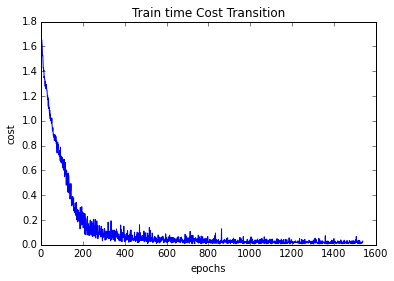

In [32]:
plt.plot(cost)
plt.ylabel('cost')
plt.xlabel('epochs')
plt.title('Train time Cost Transition')
plt.show()
plt.savefig('cost')

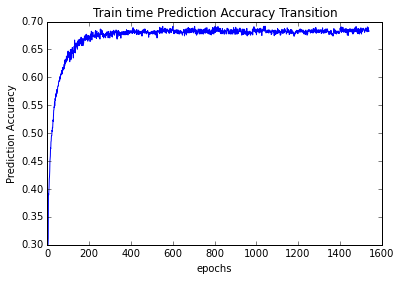

In [33]:
plt.plot(errors)
plt.ylabel('Prediction Accuracy')
plt.xlabel('epochs')
plt.title('Train time Prediction Accuracy Transition')
plt.show()
plt.savefig('prediction_accuracy')

In [24]:
A = Params[0].get_value()

In [26]:
A = A.reshape(64,1*7*7)

In [27]:
image = T.flatten(Params[0], outdim=2)
print image.shape

Shape.0


In [28]:
print A.shape

(64, 49)


In [29]:
from utils import tile_raster_images

In [30]:
filters = tile_raster_images(A ,(7,7) , (7,7) ,(3,3) )

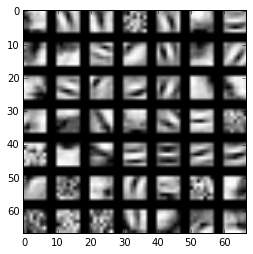

In [31]:
plt.imshow(filters,cmap = cm.Greys_r)